In [1]:

import dlib
import cv2 as cv
from mtcnn.mtcnn import MTCNN
from tqdm import tqdm
from tqdm import tnrange
import numpy as np
from IPython.display import Image

/data/soft/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
pNum = "T000001"

proj = "/root/proj/SecurityAI_Round1"
pimg = f"{proj}/Data/images"
pmdl = f"{proj}/Model"
pout = f"{proj}/Out/{pNum}"

In [3]:
modelv = "_81"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(f"{pmdl}/shape_predictor{modelv}_face_landmarks.dat")

In [4]:
# st, ed = 1, 100
st, ed = 1, 712


In [5]:
def f_xy(images):
    result = []
    cv_face = detector(cv.cvtColor(images, cv.COLOR_BGR2GRAY), 1)
    for face in cv_face:
        shape = predictor(images, face)
        for pt in shape.parts():
            result.append((pt.y, pt.x))
    return result

print(
    len(f_xy(cv.imread(f"{pimg}/00001.jpg"))), 
    len(f_xy(cv.imread(f"{pimg}/00003.jpg")))
)
%time len(f_xy(cv.imread(f"{pimg}/00001.jpg")))


81 0
CPU times: user 10.1 ms, sys: 928 µs, total: 11 ms
Wall time: 10.5 ms


81

In [6]:
%time dmtcnn = MTCNN()

def f_xy_mtcnn(images):
    rdetector = dmtcnn.detect_faces(images)
    if rdetector:
        x, y, w, h = rdetector[0]["box"]
        min_y, max_y, min_x, max_x = max(y,0), min(max(y,0)+h,112), max(x,0), min(max(x,0)+w,112)
        return min_y, max_y, min_x, max_x
    else:
        n = 18
        min_x, min_y = 0, 0
        max_x, max_y = 112, 112
        min_y, max_y, min_x, max_x = min_y+n, max_y-n, min_x+n, max_x-n
        return min_y, max_y, min_x, max_x

print(
    f_xy_mtcnn(cv.imread(f"{pimg}/00001.jpg")), 
    f_xy_mtcnn(cv.imread(f"{pimg}/00003.jpg")),
    f_xy_mtcnn(cv.imread(f"{pimg}/00489.jpg"))
)
%time f_xy_mtcnn(cv.imread(f"{pimg}/00001.jpg"))


CPU times: user 204 ms, sys: 14.6 ms, total: 218 ms
Wall time: 210 ms
(17, 112, 14, 99) (14, 111, 2, 80) (18, 94, 18, 94)
CPU times: user 25.3 ms, sys: 1.29 ms, total: 26.6 ms
Wall time: 18.8 ms


(17, 112, 14, 99)

In [7]:
def f_lf1(f1, f2):
    return np.sqrt(np.sum(np.square(f1 - f2)))

print("SAME:%.6f" % f_lf1(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00001.jpg")))
print("DIFF:%.6f" % f_lf1(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00002.jpg")))
print("DIFF:%.6f" % f_lf1(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00406.jpg")))

%time f_lf1(cv.imread(f"{pimg}/00001.jpg"), cv.imread(f"{pimg}/00002.jpg"))


SAME:0.000000
DIFF:1974.158302
DIFF:1993.636627
CPU times: user 1.09 ms, sys: 12 µs, total: 1.11 ms
Wall time: 1.12 ms


1974.1583016566833

In [8]:
"""
简单思路
    1\根据L2距离找出最近人脸；
    2\根据clip限制M68取结果；
    # 是否可以考虑放大；
"""

def frun(tpath, time):
    d = 25.5 # 25.0
    
    for i in tnrange(st, ed+1, desc=f"{time}"):
        pi = f"{pimg}/"+f"00000{i}"[-5:]+".jpg"
        op = f"{pout}/images/"+f"00000{i}"[-5:]+".jpg"

        img = cv.imread(pi)
        min_yl, max_yl, min_xl, max_xl = 112, 0, 112, 0
        imgj, min_p012 = 1, 99999.0
        
        img_m68 = f_xy(img)
        if img_m68:
            n = 6
            yl, xl = [i[0] for i in img_m68], [i[1] for i in img_m68]
            min_yl, max_yl, min_xl, max_xl = min(yl), max(yl), min(xl), max(xl)
            print(i, min_yl, max_yl, min_xl, max_xl)
            min_yl, max_yl, min_xl, max_xl = min_yl-n, max_yl-n, min_xl, max_xl-n
            
        else:
            # n = 18
            # min_yl, max_yl, min_xl, max_xl = 0, 112, 0, 112
            # print(i, min_yl, max_yl, min_xl, max_xl)
            # min_yl, max_yl, min_xl, max_xl = min_yl+n, max_yl-n, min_xl+n, max_xl-n
            
            min_yl, max_yl, min_xl, max_xl = f_xy_mtcnn(img)
            print(i, min_yl, max_yl, min_xl, max_xl)
            
        for imgi in range(st, ed+1, 1):
            imgx = cv.imread(tpath+f"00000{imgi}"[-5:]+".jpg")
            p012 = f_lf1(img[min_yl:max_yl, min_xl:max_xl], imgx[min_yl:max_yl, min_xl:max_xl])
            
            if p012 < min_p012 and imgi != i:
                imgj, min_p012 = imgi, p012
        
        print(f"{i},{imgj}, Avg:{min_p012:.{6}}")
        
        img_o = img.copy()
        img_g = cv.imread(tpath+f"00000{imgj}"[-5:]+".jpg")
        # img_g = cv.imread(f"{proj}/Data/X.jpg")
        
        img_o[min_yl:max_yl, min_xl:max_xl] = img_g[min_yl:max_yl, min_xl:max_xl]
        
        img_o = np.clip(img_o, img-d, img+d)
        cv.imwrite(op, img_o)
        
frun(f"{pimg}/", 0)
# 1, 37.7798


1 16 117 19 102
1,401, Avg:1485.22
2 5 118 14 104
2,58, Avg:143.105
3 14 111 2 80
3,549, Avg:1499.64
4 11 116 -3 85
4,1, Avg:0.0
5 13 115 23 105
5,571, Avg:1477.52
6 13 116 9 97
6,245, Avg:1514.5
7 11 111 10 87
7,590, Avg:1511.36
8 13 117 27 108
8,146, Avg:1468.37
9 17 119 28 115
9,704, Avg:1513.59
10 29 114 22 94
10,219, Avg:1242.91
11 15 111 25 106
11,306, Avg:1423.49
12 21 112 16 101
12,612, Avg:1510.67
13 16 115 19 98
13,112, Avg:1425.47
14 15 116 23 108
14,523, Avg:1470.66
15 11 116 25 113
15,449, Avg:1563.79
16 14 116 31 110
16,66, Avg:1440.55
17 17 118 12 97
17,571, Avg:1455.7
18 7 115 19 106
18,229, Avg:1534.26
19 14 115 3 89
19,121, Avg:1513.89
20 12 115 -1 86
20,1, Avg:0.0
21 20 112 8 88
21,149, Avg:1423.08
22 16 111 19 95
22,210, Avg:1372.45
23 14 116 9 90
23,600, Avg:1465.19
24 17 116 3 89
24,155, Avg:1494.83
25 12 115 17 101
25,705, Avg:1509.15
26 16 118 10 89
26,474, Avg:1490.09
27 18 117 -2 83
27,1, Avg:0.0
28 16 119 20 101
28,294, Avg:1509.37
29 15 115 5 90
29,345, Avg:

226,311, Avg:1479.83
227 17 116 5 88
227,653, Avg:1490.86
228 12 114 15 94
228,74, Avg:1465.12
229 14 116 10 97
229,301, Avg:1485.36
230 24 112 18 99
230,17, Avg:1452.29
231 15 115 17 98
231,453, Avg:1332.94
232 15 114 13 93
232,653, Avg:1436.15
233 13 117 22 96
233,264, Avg:1407.04
234 11 117 33 117
234,446, Avg:1538.23
235 15 115 17 106
235,101, Avg:1473.91
236 17 118 11 94
236,433, Avg:1467.74
237 16 117 14 97
237,219, Avg:1480.01
238 13 118 5 87
238,144, Avg:1492.57
239 19 114 31 110
239,599, Avg:1371.02
240 18 117 4 90
240,273, Avg:1493.59
241 15 115 30 113
241,104, Avg:1452.45
242 16 115 21 98
242,182, Avg:1393.33
243 16 115 21 101
243,138, Avg:1436.61
244 16 116 11 101
244,138, Avg:1506.11
245 14 114 5 87
245,6, Avg:1439.54
246 18 117 6 91
246,632, Avg:1522.52
247 6 117 -5 81
247,1, Avg:0.0
248 17 116 26 105
248,179, Avg:1444.92
249 12 118 27 115
249,571, Avg:1540.62
250 11 115 8 92
250,418, Avg:1493.37
251 16 119 23 104
251,311, Avg:1480.52
252 16 116 12 93
252,222, Avg:1455.0


445,269, Avg:1480.78
446 12 114 35 115
446,234, Avg:1466.96
447 15 115 27 108
447,490, Avg:1421.37
448 14 115 11 95
448,402, Avg:1475.99
449 14 117 18 104
449,523, Avg:1517.73
450 17 114 22 103
450,298, Avg:1446.95
451 11 117 4 88
451,608, Avg:1518.44
452 18 117 10 91
452,656, Avg:1487.91
453 12 116 13 96
453,231, Avg:1376.95
454 17 118 23 106
454,523, Avg:1475.73
455 17 116 20 102
455,599, Avg:1458.91
456 15 117 7 85
456,121, Avg:1450.88
457 12 115 6 89
457,572, Avg:1480.18
458 20 114 10 94
458,702, Avg:1458.71
459 16 117 33 115
459,180, Avg:1488.0
460 17 112 15 100
460,150, Avg:1527.57
461 15 116 9 96
461,625, Avg:1493.48
462 18 117 16 100
462,402, Avg:1460.34
463 14 115 18 106
463,221, Avg:1501.65
464 15 117 8 89
464,706, Avg:1499.58
465 10 115 13 96
465,88, Avg:1534.96
466 14 110 8 89
466,80, Avg:1453.44
467 15 114 16 94
467,39, Avg:1387.98
468 20 115 19 99
468,711, Avg:1391.19
469 12 116 25 104
469,282, Avg:1474.02
470 12 115 9 89
470,15, Avg:1510.85
471 9 112 15 100
471,416, Avg:

663,229, Avg:1591.51
664 15 118 19 104
664,66, Avg:1523.42
665 15 117 19 95
665,407, Avg:1418.02
666 24 112 8 84
666,167, Avg:1368.25
667 14 113 10 94
667,132, Avg:1481.69
668 15 115 23 103
668,39, Avg:1448.56
669 10 116 21 101
669,369, Avg:1483.83
670 13 118 17 102
670,185, Avg:1480.72
671 17 118 11 87
671,427, Avg:1431.34
672 14 118 3 87
672,690, Avg:1449.04
673 19 117 10 93
673,177, Avg:1501.27
674 14 115 5 88
674,482, Avg:1505.95
675 18 119 27 108
675,523, Avg:1433.78
676 11 116 10 95
676,596, Avg:1546.26
677 26 112 19 93
677,444, Avg:1368.38
678 14 116 11 90
678,229, Avg:1462.88
679 14 117 31 114
679,264, Avg:1453.72
680 12 118 5 92
680,690, Avg:1524.85
681 16 117 24 105
681,515, Avg:1424.87
682 21 115 19 104
682,441, Avg:1446.84
683 10 115 12 99
683,306, Avg:1543.92
684 12 116 15 93
684,306, Avg:1480.56
685 15 118 16 100
685,42, Avg:1503.23
686 18 115 14 94
686,683, Avg:1415.28
687 15 116 19 94
687,437, Avg:1407.0
688 9 118 6 98
688,301, Avg:1580.09
689 10 115 7 86
689,112, Avg:1

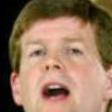

In [9]:
Image(filename=f"{pimg}/00001.jpg", width=300, height=300)

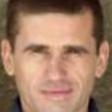

In [10]:
Image(filename=f"{pimg}/00401.jpg", width=300, height=300)

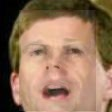

In [11]:
Image(filename=f"{pout}/images/00001.jpg", width=300, height=300)

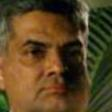

In [12]:
Image(filename=f"{pimg}/00003.jpg", width=300, height=300)

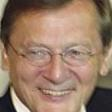

In [13]:
Image(filename=f"{pimg}/00307.jpg", width=300, height=300)

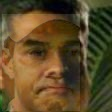

In [14]:
Image(filename=f"{pout}/images/00003.jpg", width=300, height=300)

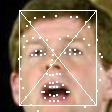

In [15]:
n = 6
pi = f"{pimg}/"+f"00001.jpg"
op = f"{proj}/Data/Y.jpg"
img = cv.imread(pi)

min_x, min_y = 112, 112
max_x, max_y = 0, 0

for if_xy in f_xy(img):
    y, x = if_xy
    if 0 <= x < 112 and 0 <= y < 112:
        img[y-1:y+1, x-1:x+1] = 255
        
        min_y, min_x = min(min_y, y), min(min_x, x)
        max_y, max_x = max(max_y, y), max(max_x, x)

min_yl, max_yl, min_xl, max_xl = min_y, max_y, min_x, max_x
min_yl, max_yl, min_xl, max_xl = min_yl-n, max_yl-n, min_xl, max_xl-n
min_y, max_y, min_x, max_x = min_yl, max_yl, min_xl, max_xl

cv.line(img, (min_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (min_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (max_x, min_y), (255, 255, 255))

cv.imwrite(op, img)
Image(filename=op, width=300, height=300)



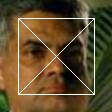

In [16]:
n = 18
pi = f"{pimg}/"+f"00003.jpg"
op = f"{proj}/Data/Y.jpg"
img = cv.imread(pi)

min_x, min_y = 0, 0
max_x, max_y = 112, 112

for if_xy in f_xy(img):
    y, x = if_xy
    if 0 <= x < 112 and 0 <= y < 112:
        img[y-1:y+1, x-1:x+1] = 255
        
        min_y, min_x = min(min_y, y), min(min_x, x)
        max_y, max_x = max(max_y, y), max(max_x, x)

min_yl, max_yl, min_xl, max_xl = min_y, max_y, min_x, max_x
min_yl, max_yl, min_xl, max_xl = min_yl+n, max_yl-n, min_xl+n, max_xl-n
min_y, max_y, min_x, max_x = min_yl, max_yl, min_xl, max_xl

cv.line(img, (min_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (min_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (max_x, min_y), (255, 255, 255))

cv.imwrite(op, img)
Image(filename=op, width=300, height=300)


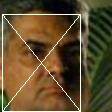

In [17]:
pi = f"{pimg}/"+f"00003.jpg"
op = f"{proj}/Data/Y.jpg"
img = cv.imread(pi)

min_y, max_y, min_x, max_x = f_xy_mtcnn(img)

cv.line(img, (min_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (min_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (max_x, min_y), (255, 255, 255))

cv.imwrite(op, img)
Image(filename=op, width=300, height=300)

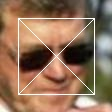

In [18]:
pi = f"{pimg}/"+f"00489.jpg"
op = f"{proj}/Data/Y.jpg"
img = cv.imread(pi)

min_y, max_y, min_x, max_x = f_xy_mtcnn(img)

cv.line(img, (min_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (min_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (min_x, max_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, min_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, min_y), (max_x, min_y), (255, 255, 255))

cv.line(img, (max_x, max_y), (max_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (min_x, max_y), (255, 255, 255))
cv.line(img, (max_x, max_y), (max_x, min_y), (255, 255, 255))

cv.imwrite(op, img)
Image(filename=op, width=300, height=300)


In [19]:
# cosin相似度（余弦相似度）
# https://blog.csdn.net/weixin_39121325/article/details/84187453

# dlib model 81
# https://blog.csdn.net/weixin_41010198/article/details/88827209

# shape_predictor_81_face_landmarks
# https://github.com/codeniko/shape_predictor_81_face_landmarks

# 
# https://pan.baidu.com/s/100hXZAxtRlE_Z2nDDzHtIQ
# https://segmentfault.com/a/1190000015917420
# mtcnn



In [20]:
! ls

record.txt  run.py  run_v0.1.ipynb  run_v0.2.ipynb  run_v0.3.ipynb  test.ipynb
